In [1]:
from process_bigraph import ProcessTypes, Composite
from cdFBA import register_types, register_processes
from cdFBA.utils import get_substrates, get_reaction_map, model_from_file, get_exchanges
from process_bigraph.emitter import gather_emitter_results
from cobra.io import load_model, read_sbml_model
from cobra.medium import minimal_medium
from vivaCRM.crm_gsmm_golford import (
    get_crm_goldford_emitter, 
    plot_crm_goldford_simulation)
from vivaCRM.crm_cdfba_utils import initial_environment, env_to_mcrm_state
from CRM.crm_gsmm_goldford_utils import ( 
    extract_yields, 
    extract_byproducts, 
    extract_uptake_rates, 
    run_mcrm_from_extractions, 
    plot_mcrm, 
    build_crm_goldford_config, 
    make_initial_state, 
    extract_yields_agora,
    extract_byproducts_agora,
    extract_uptake_rates_agora)
from vivaCRM.new_crm_gsmm_golford import build_params, MCRM_Process

In [2]:
def get_reaction_map(model_file="textbook", exchanges=None):
    """Returns a reaction_name_map dictionary from a medium dictionary as obtained
    from model.medium or cobra.medium.minimum_medium()
    Parameters:
        model_file : str, file path or BiGG Model ID
        exchanges : lst, list of names of substrates required by the model organism
    Returns:
        reaction_name_map : dict, maps substrate names to reactions
    """
    if isinstance(model_file, str):
        model = model_from_file(model_file)
    else:
        model = model_file
    if exchanges is None:
        exchanges = get_exchanges(model)
    reaction_map = {
        list(getattr(model.reactions, i).metabolites.keys())[0].name: i
        for i in exchanges if hasattr(model.reactions, i)
    }
    # substrates = get_substrates(model, exchanges)
    # ids = exchanges
    # reaction_name_map = {}
    # for i in range(len(substrates)):
    #     reaction_name_map[substrates[i]] = ids[i]
    return reaction_map

In [3]:
gut_models = {
    "B_thetaiotaomicron": "/Users/edwin/Downloads/reconstructions/sbml/Bacteroides_thetaiotaomicron_VPI_5482.xml",
    "E_rectale": "/Users/edwin/Downloads/reconstructions/GSMM/Eubacterium_rectale_ATCC_33656.xml",
    "Methanobrevibacter_smithii": "/Users/edwin/Downloads/reconstructions/sbml/Methanobrevibacter_smithii_ATCC_35061.xml",
}
models = {k: read_sbml_model(v) for k, v in gut_models.items()}

In [4]:
BT = models["B_thetaiotaomicron"]
ER = models["E_rectale"]
MS = models["Methanobrevibacter_smithii"]

In [5]:
species_names  = ["B_thetaiotaomicron", "E_rectale"]
resource_names = ["EX_hspg(e)", "EX_ac(e)", "EX_but(e)"]  

In [6]:
def get_all_substrates(models, exchanges):
    resource_names = []
    for model in models:
        resource_names.extend(get_substrates(model, exchanges)) 
    resource_names = list(set(resource_names))
    return resource_names

In [7]:
def get_all_reaction_map(models, exchanges):
    reaction_map = {}
    for model in models:
        reaction_map.update(get_reaction_map(model, exchanges))
    return reaction_map

In [8]:
substrate_names = get_all_substrates([BT, ER], resource_names)

In [9]:
reaction_map = get_all_reaction_map([BT, ER], resource_names)

In [10]:
resource_names

['EX_hspg(e)', 'EX_ac(e)', 'EX_but(e)']

In [11]:
reaction_map

{'heparan sulfate proteoglycan': 'EX_hspg(e)',
 'acetate': 'EX_ac(e)',
 'butyrate': 'EX_but(e)'}

In [12]:
models = {
    "B_thetaiotaomicron": BT,
    "E_rectale": ER,
}
biomass_id = {
    "B_thetaiotaomicron": "EX_biomass(e)",   # set to the exact biomass rxn id in your model
    "E_rectale": "EX_biomass(e)",
}

# --- 1) Exchanges to track (use YOUR IDs exactly) ---
resource_ids = [values for values in reaction_map.values()]

# --- 2) Extract yields, uptakes, byproducts for each species under a unified medium ---
extractions = {
    "B_thetaiotaomicron": {
        "yields":     extract_yields_agora(models["B_thetaiotaomicron"], resource_ids,
                                           biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                           use_pfba=False),
        "byproducts": extract_byproducts_agora(models["B_thetaiotaomicron"], resource_ids,
                                               biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                               use_pfba=False),
        "uptakes":    extract_uptake_rates_agora(models["B_thetaiotaomicron"], resource_ids,
                                                 biomass_rxn_id=biomass_id["B_thetaiotaomicron"],
                                                 use_pfba=False),
    },
    "E_rectale": {
        "yields":     extract_yields_agora(models["E_rectale"], resource_ids,
                                           biomass_rxn_id=biomass_id["E_rectale"],
                                           use_pfba=False),
        "byproducts": extract_byproducts_agora(models["E_rectale"], resource_ids,
                                               biomass_rxn_id=biomass_id["E_rectale"],
                                               use_pfba=False),
        "uptakes":    extract_uptake_rates_agora(models["E_rectale"], resource_ids,
                                                 biomass_rxn_id=biomass_id["E_rectale"],
                                                 use_pfba=False),
    }
}

# --- 3) Monod Km per resource (tune later) ---
Km = {values: 0.5 for values in reaction_map.values()}

# --- 4) Build CRM config (Goldford-style) ---
cfg = build_crm_goldford_config(
    extractions,
    resource_ids,
    Km,
    maintenance_by_species={"B_thetaiotaomicron": 0.2, "E_rectale": 0.2},
    dilution=0.0,
    feed_by_resource={},              # e.g., set EX_hspg(e) here if you run as chemostat (dilution>0)
    resource_loss_by_resource={},     # optional abiotic loss rates per resource
)

# --- 5) Initial state: HSPG present; acetate/butyrate start at 0 ---
state0 = make_initial_state(
    ["B_thetaiotaomicron", "E_rectale"],
    resource_ids,
    n0_by_species={"B_thetaiotaomicron": 0.1, "E_rectale": 0.1},
    R0_by_resource={"EX_hspg(e)": 20.0, "EX_ac(e)": 0.0, "EX_but(e)": 0.0}
)

104.30368212805854
104.30368212805875
56.52570685447269
56.52570685447261


In [13]:
# build params
params = build_params(
    cfg['species_names'], cfg['resource_names'],
    yields_map=cfg['yields'],
    vmax_map=cfg['resource_uptakes'],
    maintenance_map=cfg['maintenance'],
    Km_map=cfg['Km'],
    byproducts_map=cfg['byproducts'],
    dilution=cfg['dilution'],
    feed_map=cfg['feed'],
    resource_loss_map=cfg['resource_loss'],
)

In [34]:
adaptive_spec = {
    "adaptive_crm": {
        "_type": "process",
        "address": "local:MCRM_Process",
        "config": {
            "species_names": cfg["species_names"],
            "resource_names": cfg["resource_names"],
            "params": params,
            "method": "RK45",
            "rtol": 1e-5, "atol": 1e-7, "max_step": 0.05,
            "clip_nonnegative": True,
        },
        "inputs": {"shared_environment": ["Shared Environment"]},
        "outputs": {"update": ["dFBA Results", "CRM"]},
        "interval": 0.5,
    }
}

env = initial_environment(
    volume=1.0,
    species_list=species_names,
    substrates=substrate_names,
    # overrides are optional; here we pin substrates and species starts:
    resource_overrides={"heparan sulfate proteoglycan": 20.0, "acetate": 0.0, "butyrate": 0.0},
    biomass_overrides={"B_thetaiotaomicron": 0.1, "E_rectale": 0.1},
    default_resource=0.0,   # anything not listed starts at 0
)

shared_environment = {"Shared Environment": env}

update_env = {'update environment': {'_type': 'process',
                        'address': 'local:UpdateEnvironment',
                        'config': {},
                        'inputs': {'shared_environment': ['Shared Environment'],
                                   'species_updates': ['dFBA Results']},
                        'outputs': {'counts': ['Shared Environment',
                                               'counts']}}}


In [35]:
substrate_names

['butyrate', 'acetate', 'heparan sulfate proteoglycan']

In [36]:
env

{'volume': 1.0,
 'counts': {'butyrate': 0.0,
  'acetate': 0.0,
  'heparan sulfate proteoglycan': 20.0,
  'B_thetaiotaomicron': 0.1,
  'E_rectale': 0.1},
 'concentrations': {'butyrate': 0.0,
  'acetate': 0.0,
  'heparan sulfate proteoglycan': 20.0,
  'B_thetaiotaomicron': 0.1,
  'E_rectale': 0.1}}

In [37]:
spec = {**adaptive_spec, **shared_environment}
combined_names = []
combined_names.extend(substrate_names)
combined_names.extend(species_names)
crm_update = {
    name: 0 for name in combined_names
}
dfba_update = {
    "CRM": crm_update
}
spec.update(
    {
        "dFBA Results": dfba_update
    }
)
state_keys = ["Shared Environment", "global_time"]
spec["emitter"] = get_crm_goldford_emitter(state_keys)

In [40]:
spec.update(update_env)

In [41]:
spec

{'adaptive_crm': {'_type': 'process',
  'address': 'local:MCRM_Process',
  'config': {'species_names': ['B_thetaiotaomicron', 'E_rectale'],
   'resource_names': ['EX_hspg(e)', 'EX_ac(e)', 'EX_but(e)'],
   'params': MCRMParams(yields=array([[0., 0., 0.],
          [0., 0., 0.]]), vmax=array([[0., 0., 0.],
          [0., 0., 0.]]), B=array([[[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]],
   
          [[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]]), Km=array([0.5, 0.5, 0.5]), maintenance=array([0.2, 0.2]), dilution=0.0, feed=None, resource_loss=array([0., 0., 0.])),
   'method': 'RK45',
   'rtol': 1e-05,
   'atol': 1e-07,
   'max_step': 0.05,
   'clip_nonnegative': True},
  'inputs': {'shared_environment': ['Shared Environment']},
  'outputs': {'update': ['dFBA Results', 'CRM']},
  'interval': 0.5},
 'Shared Environment': {'volume': 1.0,
  'counts': {'butyrate': 0.0,
   'acetate': 0.0,
   'heparan sulfate proteoglycan': 20.0,
   'B_thetaiotaomicron': 

In [42]:
species_names

['B_thetaiotaomicron', 'E_rectale']

In [43]:
combined_names

['butyrate',
 'acetate',
 'heparan sulfate proteoglycan',
 'B_thetaiotaomicron',
 'E_rectale']

In [44]:
core = ProcessTypes()
core = register_types(core)
core.register_process("MCRM_Process", MCRM_Process)
sim = Composite({"state": spec}, core=core)

In [45]:
sim.run(10)

In [46]:
results = gather_emitter_results(sim)[('emitter',)]


In [47]:
results

[{'global_time': 0.0,
  'Shared Environment': {'concentrations': {'butyrate': 0.0,
    'acetate': 0.0,
    'heparan sulfate proteoglycan': 20.0,
    'B_thetaiotaomicron': 0.1,
    'E_rectale': 0.1},
   'counts': {'butyrate': 0.0,
    'acetate': 0.0,
    'heparan sulfate proteoglycan': 20.0,
    'B_thetaiotaomicron': 0.1,
    'E_rectale': 0.1},
   'volume': 1.0}}]

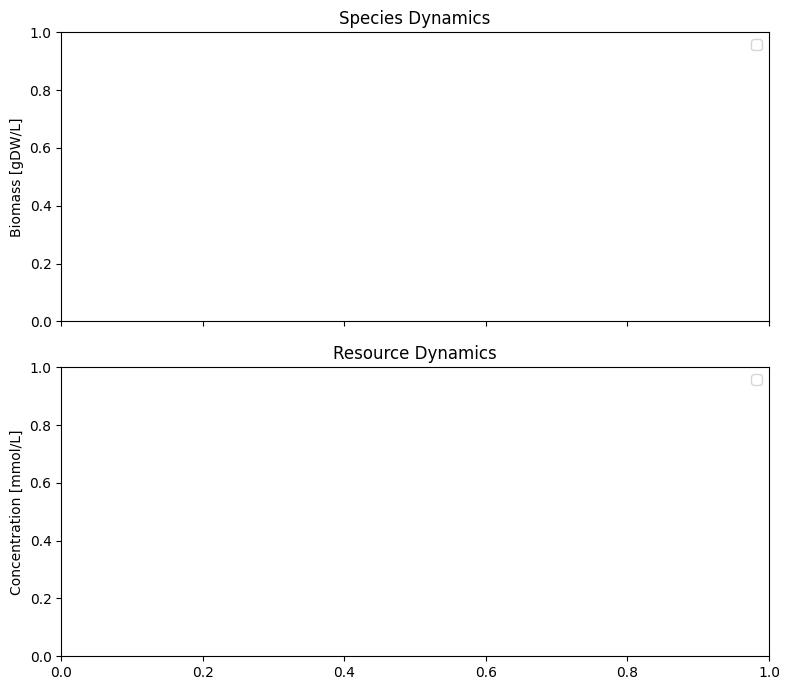

In [48]:
plot_crm_goldford_simulation(results)